In [1]:
import numpy as np
import os
from glob import iglob
from collections import defaultdict
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
from data_extraction import *



defaultdict(<class 'list'>, {20000.0: [14.395758061, 10.794398341, 10.729266083, 10.837266337, 10.559179035], 15000.0: [16.613098945, 16.977159631, 11.508962681, 15.010787749, 10.958720499], 10000.0: [12.230470622, 11.550575327, 11.280056839, 11.724253612, 12.334348583], 5000.0: [13.414762932, 13.66657297, 13.37174435, 12.898673401, 13.502907358], 1000.0: [25.953084336, 26.026381907, 25.267830402, 25.149868179, 26.370428001]})
[20000. 15000. 10000.  5000.  1000.]


/home/sthomas/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/sthomas/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/sthomas/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/sthomas/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/sthomas/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure i

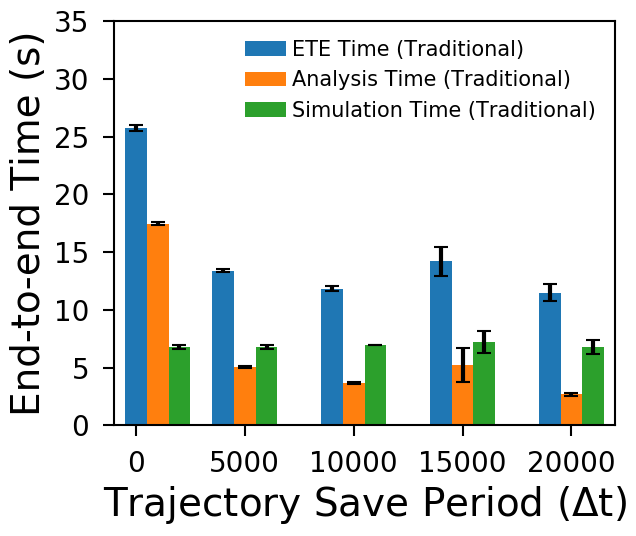

In [2]:
import numpy as np
import os
from glob import iglob
from collections import defaultdict
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats

def timestamp_to_seconds(t):
    return sum(float(n) * m for n, m in zip(reversed(t), (1, 60, 3600)))

# This will return absolute paths
paths = {'sequential_using_mdtraj':'Traditional'}
for path,legend in paths.items():
    total_times = defaultdict(list)
    sim_time_dict = defaultdict(list)
    a_time_dict = defaultdict(list)
    log_files = [os.path.abspath(f) for f in iglob('{}/slurm*'.format(path), recursive=True)]
    for log_file in log_files:
        #print(log_file)
        total_time=None
        analysis_time=0
        dump_interval = None
        L=0
        N=None
        sim_times=[]
        with open(log_file) as fp:
            line = fp.readline()
            #print(line)
            while line:
                if 'DUMP_INTERVAL' in line:
                    #print(line)
                    values = line.split(':')
                    if float(values[1]) >500:
                        dump_interval = float(values[1])
                if 'Total wall time' in line:
                    values = line.split(':')
                    sim_time = float(timestamp_to_seconds(values[1:]))
                    sim_times.append(sim_time)
                if 'ETE_TIME' in line:
                    #print(line)
                    values = line.split(':')
                    total_time = float(values[1])
                if legend == 'Plumed (Sequential)':
                    if False:
                        analysis_time_labels = ['Modify','Ouput']#'Pair','Neigh']#,'Comm','Other']#,'Modify','Ouput']
                        values = line.split('|')
                        if len(values)== 6 and any(label in values[0] for label in analysis_time_labels):
                                values = line.split('|')
                                analysis_time += float(values[2]) # Adding up times for all the analysis_time_labels
                    else:
                        if 'DISPATCH_UPDATE_TIME_rank_0' in line:
                            values = line.split(':')
                            #print(line)
                            analysis_time += float(values[1])/1e3 # convert millisecond to second
                        
                elif legend == 'Traditional':
                    if 'ANALYZE_TIME' in line:
                        #print(N,line)
                        values = line.split(':')
                        analysis_time = float(values[1])
                line = fp.readline()
            if total_time is not None and dump_interval is not None:
                total_times[dump_interval].append(total_time)
            if analysis_time >0 and dump_interval is not None:
                a_time_dict[dump_interval].append(analysis_time)
        if len(sim_times)>0 and dump_interval is not None:
            #print(log_file)
            sim_time_dict[dump_interval].append(sim_times[-1])
        else:
            #print('Could not find sim time in ',log_file)
            continue
    print(total_times)
    bar_width = 1000
    mean_tts = [np.mean(total_time_vals) for dump_interval, total_time_vals in total_times.items()]
    std_tts = [stats.sem(total_time_vals) for dump_interval, total_time_vals in total_times.items()]
    dump_intervals = total_times.keys()
    x_vals = (np.array(list(dump_intervals)))
    print(x_vals)
    plt.bar(x_vals-bar_width,
            mean_tts,
            yerr=std_tts, 
            align='center', alpha=1.0, ecolor='black', capsize=5, width=bar_width,
            label='ETE Time ({})'.format(legend))
    
    mean_tts = [np.mean(total_time_vals) for dump_interval, total_time_vals in a_time_dict.items()]
    std_tts = [stats.sem(total_time_vals) for dump_interval, total_time_vals in a_time_dict.items()]
    
    
    plt.bar(x_vals,
            mean_tts,
            yerr=std_tts, 
            align='center', alpha=1.0, ecolor='black', capsize=5, width=bar_width,
            label='Analysis Time ({})'.format(legend))
    
    mean_tts = [np.mean(total_time_vals) for dump_interval, total_time_vals in sim_time_dict.items()]
    std_tts = [stats.sem(total_time_vals) for dump_interval, total_time_vals in sim_time_dict.items()]
   
    plt.bar(x_vals+bar_width,
            mean_tts,
            yerr=std_tts, 
            align='center', alpha=1.0, ecolor='black', capsize=5, width=bar_width,
            label='Simulation Time ({})'.format(legend))
    
plt.xlabel("Trajectory Save Period ($\Delta$t)")
plt.ylabel("End-to-end Time (s)")
plt.legend(fontsize=15)
plt.ylim(0,35)
plt.xlim(-1000,22000)
plt.savefig('figure_ETE_bar.png', transparent=True)
plt.show()

[15 30 60]


/home/sthomas/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/sthomas/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


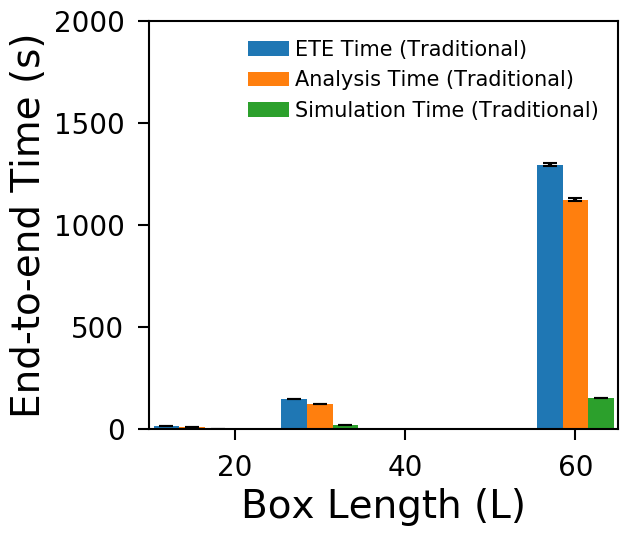

In [3]:
paths = {'sequential_vary_N':'Traditional'}
for path,legend in paths.items():
    total_times = defaultdict(list)
    sim_time_dict = defaultdict(list)
    a_time_dict = defaultdict(list)
    log_files = [os.path.abspath(f) for f in iglob('{}/slurm*'.format(path), recursive=True)]
    for log_file in log_files:
        #print(log_file)
        L=get_L(log_file)
        N=get_N(log_file)
        #print(L,N)
        dump_interval = get_dump_interval(log_file)
        
        analysis_time=get_analysis_time(log_file,legend)
        total_time=get_total_time(log_file)
        sim_time=get_sim_time(log_file,legend)
        
        total_times[L].append(total_time)
        a_time_dict[L].append(analysis_time)
        sim_time_dict[L].append(sim_time)

    #print(total_times)
    bar_width=3
    mean_tts = [np.mean(total_time_vals) for dump_interval, total_time_vals in total_times.items()]
    std_tts = [stats.sem(total_time_vals) for dump_interval, total_time_vals in total_times.items()]
    dump_intervals = total_times.keys()
    x_vals = (np.array(list(dump_intervals)))
    print(x_vals)
    plt.bar(x_vals-bar_width,
            mean_tts,
            yerr=std_tts, 
            align='center', alpha=1.0, ecolor='black', capsize=5, width=bar_width,
            label='ETE Time ({})'.format(legend))
    
    mean_tts = [np.mean(total_time_vals) for dump_interval, total_time_vals in a_time_dict.items()]
    std_tts = [stats.sem(total_time_vals) for dump_interval, total_time_vals in a_time_dict.items()]
    
    
    plt.bar(x_vals,
            mean_tts,
            yerr=std_tts, 
            align='center', alpha=1.0, ecolor='black', capsize=5, width=bar_width,
            label='Analysis Time ({})'.format(legend))
    
    mean_tts = [np.mean(total_time_vals) for dump_interval, total_time_vals in sim_time_dict.items()]
    std_tts = [stats.sem(total_time_vals) for dump_interval, total_time_vals in sim_time_dict.items()]
   
    plt.bar(x_vals+bar_width,
            mean_tts,
            yerr=std_tts, 
            align='center', alpha=1.0, ecolor='black', capsize=5, width=bar_width,
            label='Simulation Time ({})'.format(legend))
plt.xlabel("Box Length (L)")
plt.ylabel("End-to-end Time (s)")
plt.legend(fontsize=15)
plt.ylim(0,2000)
plt.xlim(10,65)
plt.savefig('figure_ETE_vary_N_bar_trad.png', transparent=True)
plt.show()

[15 30 60]


/home/sthomas/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/sthomas/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


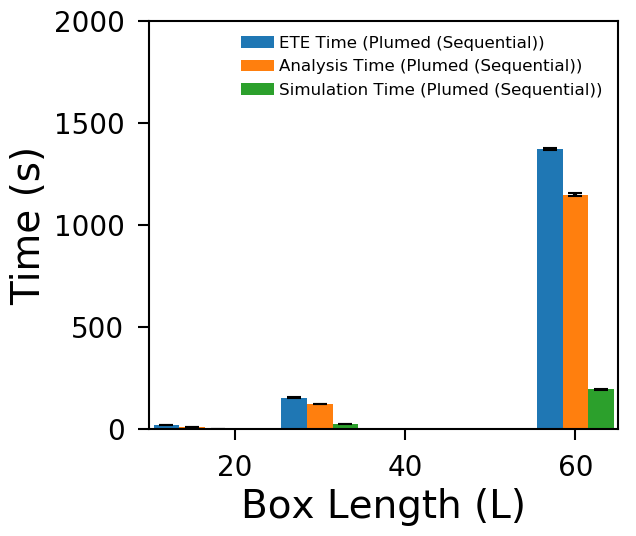

In [5]:
paths = {'sequential_in_transit_vary_N':'Plumed (Sequential)'}
for path,legend in paths.items():
    total_times = defaultdict(list)
    sim_time_dict = defaultdict(list)
    a_time_dict = defaultdict(list)
    log_files = [os.path.abspath(f) for f in iglob('{}/slurm*'.format(path), recursive=True)]
    for log_file in log_files:
        #print(log_file)
        L=get_L(log_file)
        dump_interval = get_dump_interval(log_file)
        
        analysis_time=get_analysis_time(log_file,legend)
        total_time=get_total_time(log_file)
        sim_time=get_sim_time(log_file,legend)
        
        total_times[L].append(total_time)
        a_time_dict[L].append(analysis_time)
        sim_time_dict[L].append(sim_time)

    #print(total_times)
    bar_width=3
    mean_tts = [np.mean(total_time_vals) for dump_interval, total_time_vals in total_times.items()]
    std_tts = [stats.sem(total_time_vals) for dump_interval, total_time_vals in total_times.items()]
    dump_intervals = total_times.keys()
    x_vals = (np.array(list(dump_intervals)))
    print(x_vals)
    plt.bar(x_vals-bar_width,
            mean_tts,
            yerr=std_tts, 
            align='center', alpha=1.0, ecolor='black', capsize=5, width=bar_width,
            label='ETE Time ({})'.format(legend))
    
    mean_tts = [np.mean(total_time_vals) for dump_interval, total_time_vals in a_time_dict.items()]
    std_tts = [stats.sem(total_time_vals) for dump_interval, total_time_vals in a_time_dict.items()]
    
    
    plt.bar(x_vals,
            mean_tts,
            yerr=std_tts, 
            align='center', alpha=1.0, ecolor='black', capsize=5, width=bar_width,
            label='Analysis Time ({})'.format(legend))
    
    mean_tts = [np.mean(total_time_vals) for dump_interval, total_time_vals in sim_time_dict.items()]
    std_tts = [stats.sem(total_time_vals) for dump_interval, total_time_vals in sim_time_dict.items()]
   
    plt.bar(x_vals+bar_width,
            mean_tts,
            yerr=std_tts, 
            align='center', alpha=1.0, ecolor='black', capsize=5, width=bar_width,
            label='Simulation Time ({})'.format(legend))
plt.xlabel("Box Length (L)")
plt.ylabel("Time (s)")
plt.legend(fontsize=12)
plt.ylim(0,2000)
plt.xlim(10,65)
plt.savefig('figure_ETE_vary_N_bar_plumed.png', transparent=True)
plt.show()

[13.5 28.5 58.5]
[16.5 31.5 61.5]


/home/sthomas/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/sthomas/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


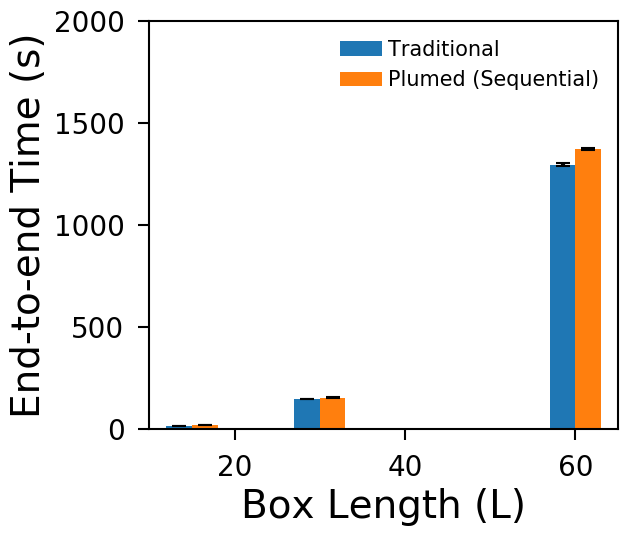

In [6]:
paths = {'sequential_vary_N':'Traditional','sequential_in_transit_vary_N':'Plumed (Sequential)'}
for index, (path,legend) in enumerate(paths.items()):
    total_times = defaultdict(list)
    sim_time_dict = defaultdict(list)
    a_time_dict = defaultdict(list)
    log_files = [os.path.abspath(f) for f in iglob('{}/slurm*'.format(path), recursive=True)]
    for log_file in log_files:
        #print(log_file)
        L=get_L(log_file)
        dump_interval = get_dump_interval(log_file)
        
        analysis_time=get_analysis_time(log_file,legend)
        total_time=get_total_time(log_file)
        sim_time=get_sim_time(log_file,legend)
        
        total_times[L].append(total_time)
        a_time_dict[L].append(analysis_time)
        sim_time_dict[L].append(sim_time)

    #print(total_times)
    bar_width=3
    mean_tts = [np.mean(total_time_vals) for dump_interval, total_time_vals in total_times.items()]
    std_tts = [stats.sem(total_time_vals) for dump_interval, total_time_vals in total_times.items()]
    dump_intervals = total_times.keys()
    x_vals = (np.array(list(dump_intervals)))
    if index==0:
        x_vals = x_vals-(bar_width/2)
    else:
        x_vals = x_vals+(bar_width/2)
    print(x_vals)
    plt.bar(x_vals,
            mean_tts,
            yerr=std_tts, 
            align='center', alpha=1.0, ecolor='black', capsize=5, width=bar_width,
            label=legend)
    
    
plt.xlabel("Box Length (L)")
plt.ylabel("End-to-end Time (s)")
plt.legend(fontsize=15)
plt.ylim(0,2000)
plt.xlim(10,65)
plt.savefig('ete_time_bar.png', transparent=True)
plt.show()

[13.5 28.5 58.5]
[16.5 31.5 61.5]


/home/sthomas/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/sthomas/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


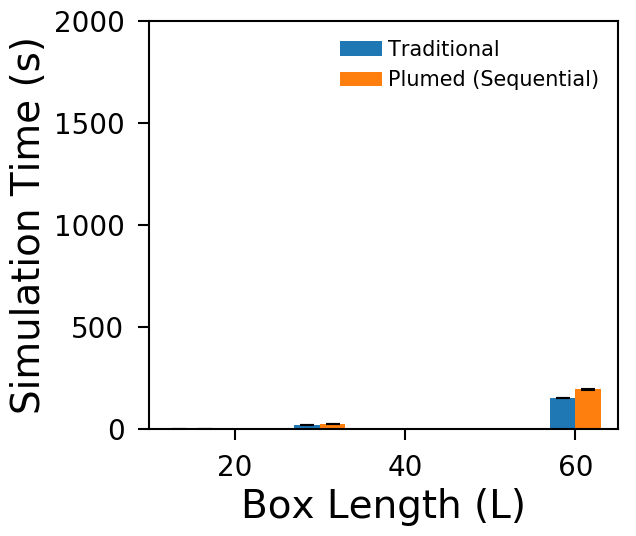

In [7]:
paths = {'sequential_vary_N':'Traditional','sequential_in_transit_vary_N':'Plumed (Sequential)'}
for index, (path,legend) in enumerate(paths.items()):
    total_times = defaultdict(list)
    sim_time_dict = defaultdict(list)
    a_time_dict = defaultdict(list)
    log_files = [os.path.abspath(f) for f in iglob('{}/slurm*'.format(path), recursive=True)]
    for log_file in log_files:
        #print(log_file)
        L=get_L(log_file)
        dump_interval = get_dump_interval(log_file)
        
        analysis_time=get_analysis_time(log_file,legend)
        total_time=get_total_time(log_file)
        sim_time=get_sim_time(log_file,legend)
        
        total_times[L].append(total_time)
        a_time_dict[L].append(analysis_time)
        sim_time_dict[L].append(sim_time)

    #print(total_times)
    bar_width=3
    mean_tts = [np.mean(total_time_vals) for dump_interval,  total_time_vals in sim_time_dict.items()]
    std_tts = [stats.sem(total_time_vals) for dump_interval, total_time_vals in sim_time_dict.items()]
    dump_intervals = total_times.keys()
    x_vals = (np.array(list(dump_intervals)))
    if index==0:
        x_vals = x_vals-(bar_width/2)
    else:
        x_vals = x_vals+(bar_width/2)
    print(x_vals)
    plt.bar(x_vals,
            mean_tts,
            yerr=std_tts, 
            align='center', alpha=1.0, ecolor='black', capsize=5, width=bar_width,
            label=legend)
    
    
plt.xlabel("Box Length (L)")
plt.ylabel("Simulation Time (s)")
plt.legend(fontsize=15)
plt.ylim(0,2000)
plt.xlim(10,65)
plt.savefig('s_time_bar.png', transparent=True)
plt.show()

[13.5 28.5 58.5]
[16.5 31.5 61.5]


/home/sthomas/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/sthomas/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


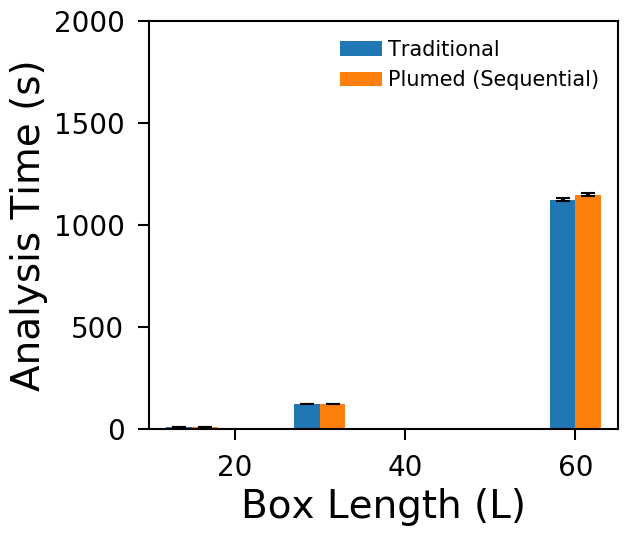

In [12]:
paths = {'sequential_vary_N':'Traditional','sequential_in_transit_vary_N':'Plumed (Sequential)'}
for index, (path,legend) in enumerate(paths.items()):
    total_times = defaultdict(list)
    sim_time_dict = defaultdict(list)
    a_time_dict = defaultdict(list)
    log_files = [os.path.abspath(f) for f in iglob('{}/slurm*'.format(path), recursive=True)]
    for log_file in log_files:
        #print(log_file)
        L=get_L(log_file)
        dump_interval = get_dump_interval(log_file)
        
        analysis_time=get_analysis_time(log_file,legend)
        total_time=get_total_time(log_file)
        sim_time=get_sim_time(log_file,legend)
        
        total_times[L].append(total_time)
        a_time_dict[L].append(analysis_time)
        sim_time_dict[L].append(sim_time)

    #print(total_times)
    bar_width=3
    mean_tts = [np.mean(total_time_vals) for dump_interval,  total_time_vals in a_time_dict.items()]
    std_tts = [stats.sem(total_time_vals) for dump_interval, total_time_vals in a_time_dict.items()]
    dump_intervals = total_times.keys()
    x_vals = (np.array(list(dump_intervals)))
    if index==0:
        x_vals = x_vals-(bar_width/2)
    else:
        x_vals = x_vals+(bar_width/2)
    print(x_vals)
    plt.bar(x_vals,
            mean_tts,
            yerr=std_tts, 
            align='center', alpha=1.0, ecolor='black', capsize=5, width=bar_width,
            label=legend)
    
    
plt.xlabel("Box Length (L)")
plt.ylabel("Analysis Time (s)")
plt.legend(fontsize=15)
plt.ylim(0,2000)
plt.xlim(10,65)
#plt.yscale('log')
plt.savefig('a_time_bar.png', transparent=True)
plt.show()

[13.5 28.5 58.5]
[16.5 31.5 61.5]


/home/sthomas/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/sthomas/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


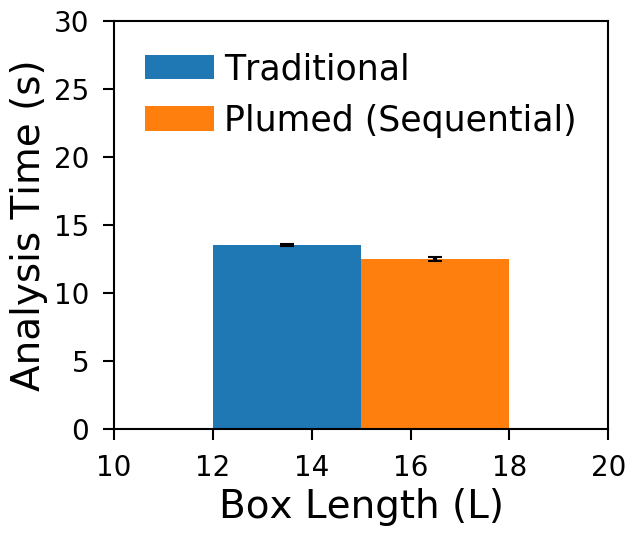

In [18]:
paths = {'sequential_vary_N':'Traditional','sequential_in_transit_vary_N':'Plumed (Sequential)'}
for index, (path,legend) in enumerate(paths.items()):
    total_times = defaultdict(list)
    sim_time_dict = defaultdict(list)
    a_time_dict = defaultdict(list)
    log_files = [os.path.abspath(f) for f in iglob('{}/slurm*'.format(path), recursive=True)]
    for log_file in log_files:
        #print(log_file)
        L=get_L(log_file)
        dump_interval = get_dump_interval(log_file)
        
        analysis_time=get_analysis_time(log_file,legend)
        total_time=get_total_time(log_file)
        sim_time=get_sim_time(log_file,legend)
        
        total_times[L].append(total_time)
        a_time_dict[L].append(analysis_time)
        sim_time_dict[L].append(sim_time)

    #print(total_times)
    bar_width=3
    mean_tts = [np.mean(total_time_vals) for dump_interval,  total_time_vals in a_time_dict.items()]
    std_tts = [stats.sem(total_time_vals) for dump_interval, total_time_vals in a_time_dict.items()]
    dump_intervals = total_times.keys()
    x_vals = (np.array(list(dump_intervals)))
    if index==0:
        x_vals = x_vals-(bar_width/2)
    else:
        x_vals = x_vals+(bar_width/2)
    print(x_vals)
    plt.bar(x_vals,
            mean_tts,
            yerr=std_tts, 
            align='center', alpha=1.0, ecolor='black', capsize=5, width=bar_width,
            label=legend)
    
    
plt.xlabel("Box Length (L)")
plt.ylabel("Analysis Time (s)")
plt.legend(fontsize=25, loc='upper right')
plt.ylim(0,30)
plt.xlim(10,20)
#plt.yscale('log')
plt.savefig('a_time_bar_zoom.png', transparent=True)
plt.show()